In [1]:
!pip install bambi numpyro jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.1 MB/s eta 0:00:00


In [2]:
import kagglehub
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import bambi as bmb
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# Data Preprocessing

In [3]:
path = kagglehub.dataset_download("jpacse/datasets-for-churn-telecom")
print("Path to dataset files:", path)

100%|██████████| 3.92M/3.92M [00:00<00:00, 51.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/jpacse/datasets-for-churn-telecom/versions/2


In [4]:
files = os.listdir(path)
print("Files in the path: %s" % files)

Files in the path: ['cell2celltrain.csv', 'cell2cellholdout.csv']


In [5]:
path = os.path.join(path, files[0])
cell2cell_data = pd.read_csv(path)
cell2cell_df = pd.DataFrame(cell2cell_data)
cell2cell_df

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
51043,3399974,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,...,0,9,No,1,60,No,3-Good,Other,Other,No
51044,3399978,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,7,No,1,80,No,5-Low,Other,Clerical,No
51045,3399990,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,9,No,0,30,No,5-Low,Other,Other,No


In [6]:
cell2cell_df.isnull().sum()

,0
CustomerID,0
Churn,0
MonthlyRevenue,156
MonthlyMinutes,156
TotalRecurringCharge,156
DirectorAssistedCalls,156
OverageMinutes,156
RoamingCalls,156
PercChangeMinutes,367
PercChangeRevenues,367


In [7]:
cell2cell_df.columns

Index(['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGro

Missing values per column:
CustomerID                     0
Churn                          0
MonthlyRevenue               156
MonthlyMinutes               156
TotalRecurringCharge         156
DirectorAssistedCalls        156
OverageMinutes               156
RoamingCalls                 156
PercChangeMinutes            367
PercChangeRevenues           367
DroppedCalls                   0
BlockedCalls                   0
UnansweredCalls                0
CustomerCareCalls              0
ThreewayCalls                  0
ReceivedCalls                  0
OutboundCalls                  0
InboundCalls                   0
PeakCallsInOut                 0
OffPeakCallsInOut              0
DroppedBlockedCalls            0
CallForwardingCalls            0
CallWaitingCalls               0
MonthsInService                0
UniqueSubs                     0
ActiveSubs                     0
ServiceArea                   24
Handsets                       1
HandsetModels                  1
CurrentEquipment

<ipython-input-8-a7b4b0aa6ba9>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")


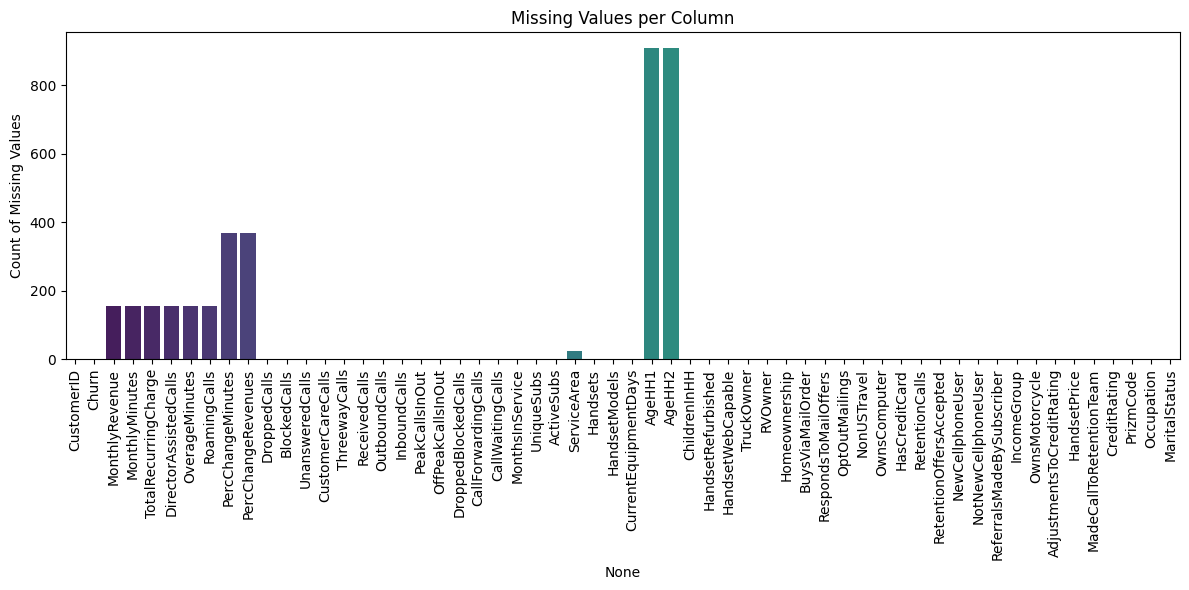

In [8]:
missing_values = cell2cell_df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Plotting missing values as a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")
plt.title("Missing Values per Column")
plt.ylabel("Count of Missing Values")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

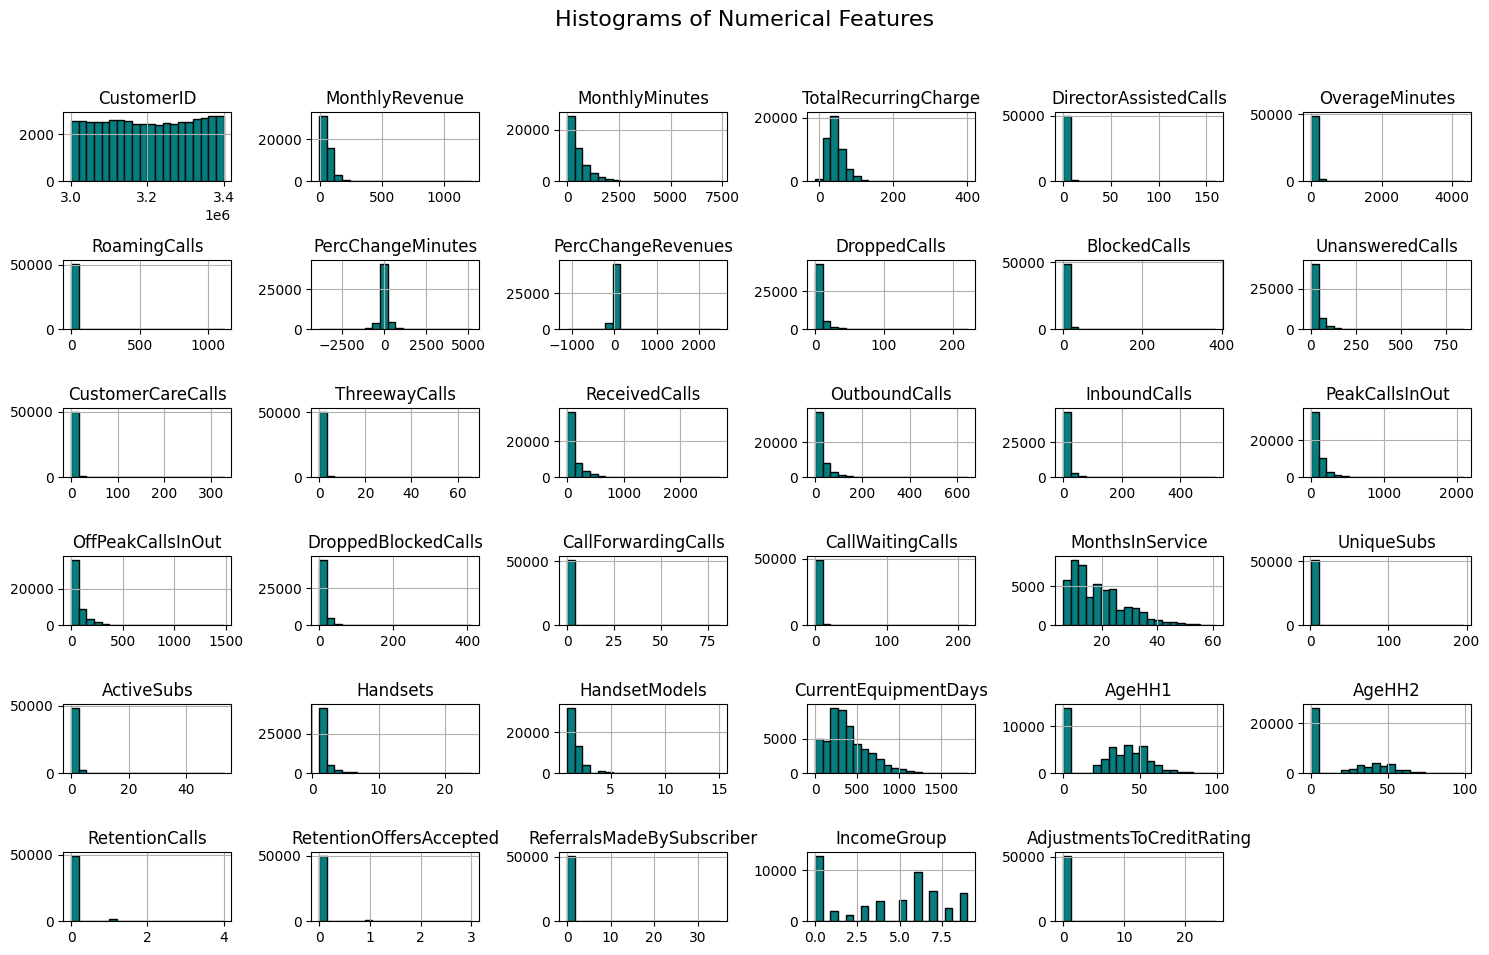

In [9]:
# --------------------------
# Histograms for Numerical Features
# --------------------------
cell2cell_df.hist(bins=20, figsize=(15, 10), color='teal', edgecolor='black')
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Target column: Churn


<ipython-input-10-9c9dda67b5fb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_column, data=cell2cell_df, palette="pastel")


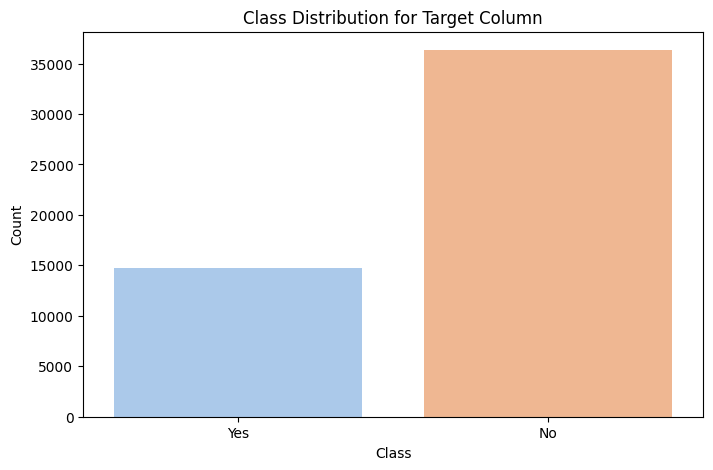

In [10]:
# --------------------------
# Class Imbalance Analysis (Last Column as Target)
# --------------------------
target_column = 'Churn'
print(f"Target column: {target_column}")

plt.figure(figsize=(8, 5))
sns.countplot(x=target_column, data=cell2cell_df, palette="pastel")
plt.title("Class Distribution for Target Column")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [11]:
numerical_features = cell2cell_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = cell2cell_df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)


Numerical Features: ['CustomerID', 'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'RetentionCalls', 'RetentionOffersAccepted', 'ReferralsMadeBySubscriber', 'IncomeGroup', 'AdjustmentsToCreditRating']
Categorical Features: ['Churn', 'ServiceArea', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'H

In [12]:
# Step 1: Handle Missing Values

num_imputer = SimpleImputer(strategy="median")
cell2cell_df[numerical_features] = num_imputer.fit_transform(cell2cell_df[numerical_features])

cat_imputer = SimpleImputer(strategy="most_frequent")
cell2cell_df[categorical_features] = cat_imputer.fit_transform(cell2cell_df[categorical_features])

In [13]:
# Step 2: Encode Categorical Features

label_encoders = {}
for col in categorical_features:
  le = LabelEncoder()
  cell2cell_df[col] = le.fit_transform(cell2cell_df[col])
  label_encoders[col] = le

In [14]:
# Step 3: Normalize numerical features for fair Chi-square test

scaler = MinMaxScaler()
cell2cell_df[numerical_features] = scaler.fit_transform(cell2cell_df[numerical_features])

#Exploratory Data Analysis

In [15]:
def univariate_analysis(df):
    print("\n=== Univariate Analysis ===")
    print(df.describe())  # Summary statistics for numerical features

    # Histograms for numerical features
    df.hist(figsize=(40, 20), bins=30, edgecolor="black")
    plt.suptitle("Univariate Analysis: Histograms", fontsize=14)
    plt.show()

    # Boxplots for numerical features
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df)
    plt.xticks(rotation=90)
    plt.title("Univariate Analysis: Boxplots")
    plt.show()

In [16]:
def bivariate_analysis(df, target_col="Churn"):
    print("\n=== Bivariate Analysis ===")

    # Correlation matrix for numerical features
    plt.figure(figsize=(20, 12))
    sns.heatmap(df.corr(), fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title("Bivariate Analysis: Correlation Matrix")
    plt.show()

    # Pairplot for top features
    top_features = df.corr()[target_col].abs().sort_values(ascending=False).index[:5]
    sns.pairplot(df[top_features])
    plt.suptitle("Bivariate Analysis: Pairplot of Top Features", fontsize=14)
    plt.show()

    # Boxplot for categorical features against Churn
    categorical_cols = df.select_dtypes(include=["object"]).columns
    for col in categorical_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x=df[col], y=df[target_col])
        plt.title(f"Bivariate Analysis: {col} vs {target_col}")
        plt.xticks(rotation=45)
        plt.show()


=== Univariate Analysis ===
         CustomerID         Churn  MonthlyRevenue  MonthlyMinutes  \
count  51047.000000  51047.000000    51047.000000    51047.000000   
mean       0.504897      0.288185        0.052843        0.071364   
std        0.292270      0.452922        0.036146        0.071903   
min        0.000000      0.000000        0.000000        0.000000   
25%        0.251580      0.000000        0.032394        0.021606   
50%        0.503840      0.000000        0.044431        0.049735   
75%        0.763450      1.000000        0.062730        0.098111   
max        1.000000      1.000000        1.000000        1.000000   

       TotalRecurringCharge  DirectorAssistedCalls  OverageMinutes  \
count          51047.000000           51047.000000    51047.000000   
mean               0.140692               0.005604        0.009237   
std                0.057938               0.013962        0.022324   
min                0.000000               0.000000        0.000000   

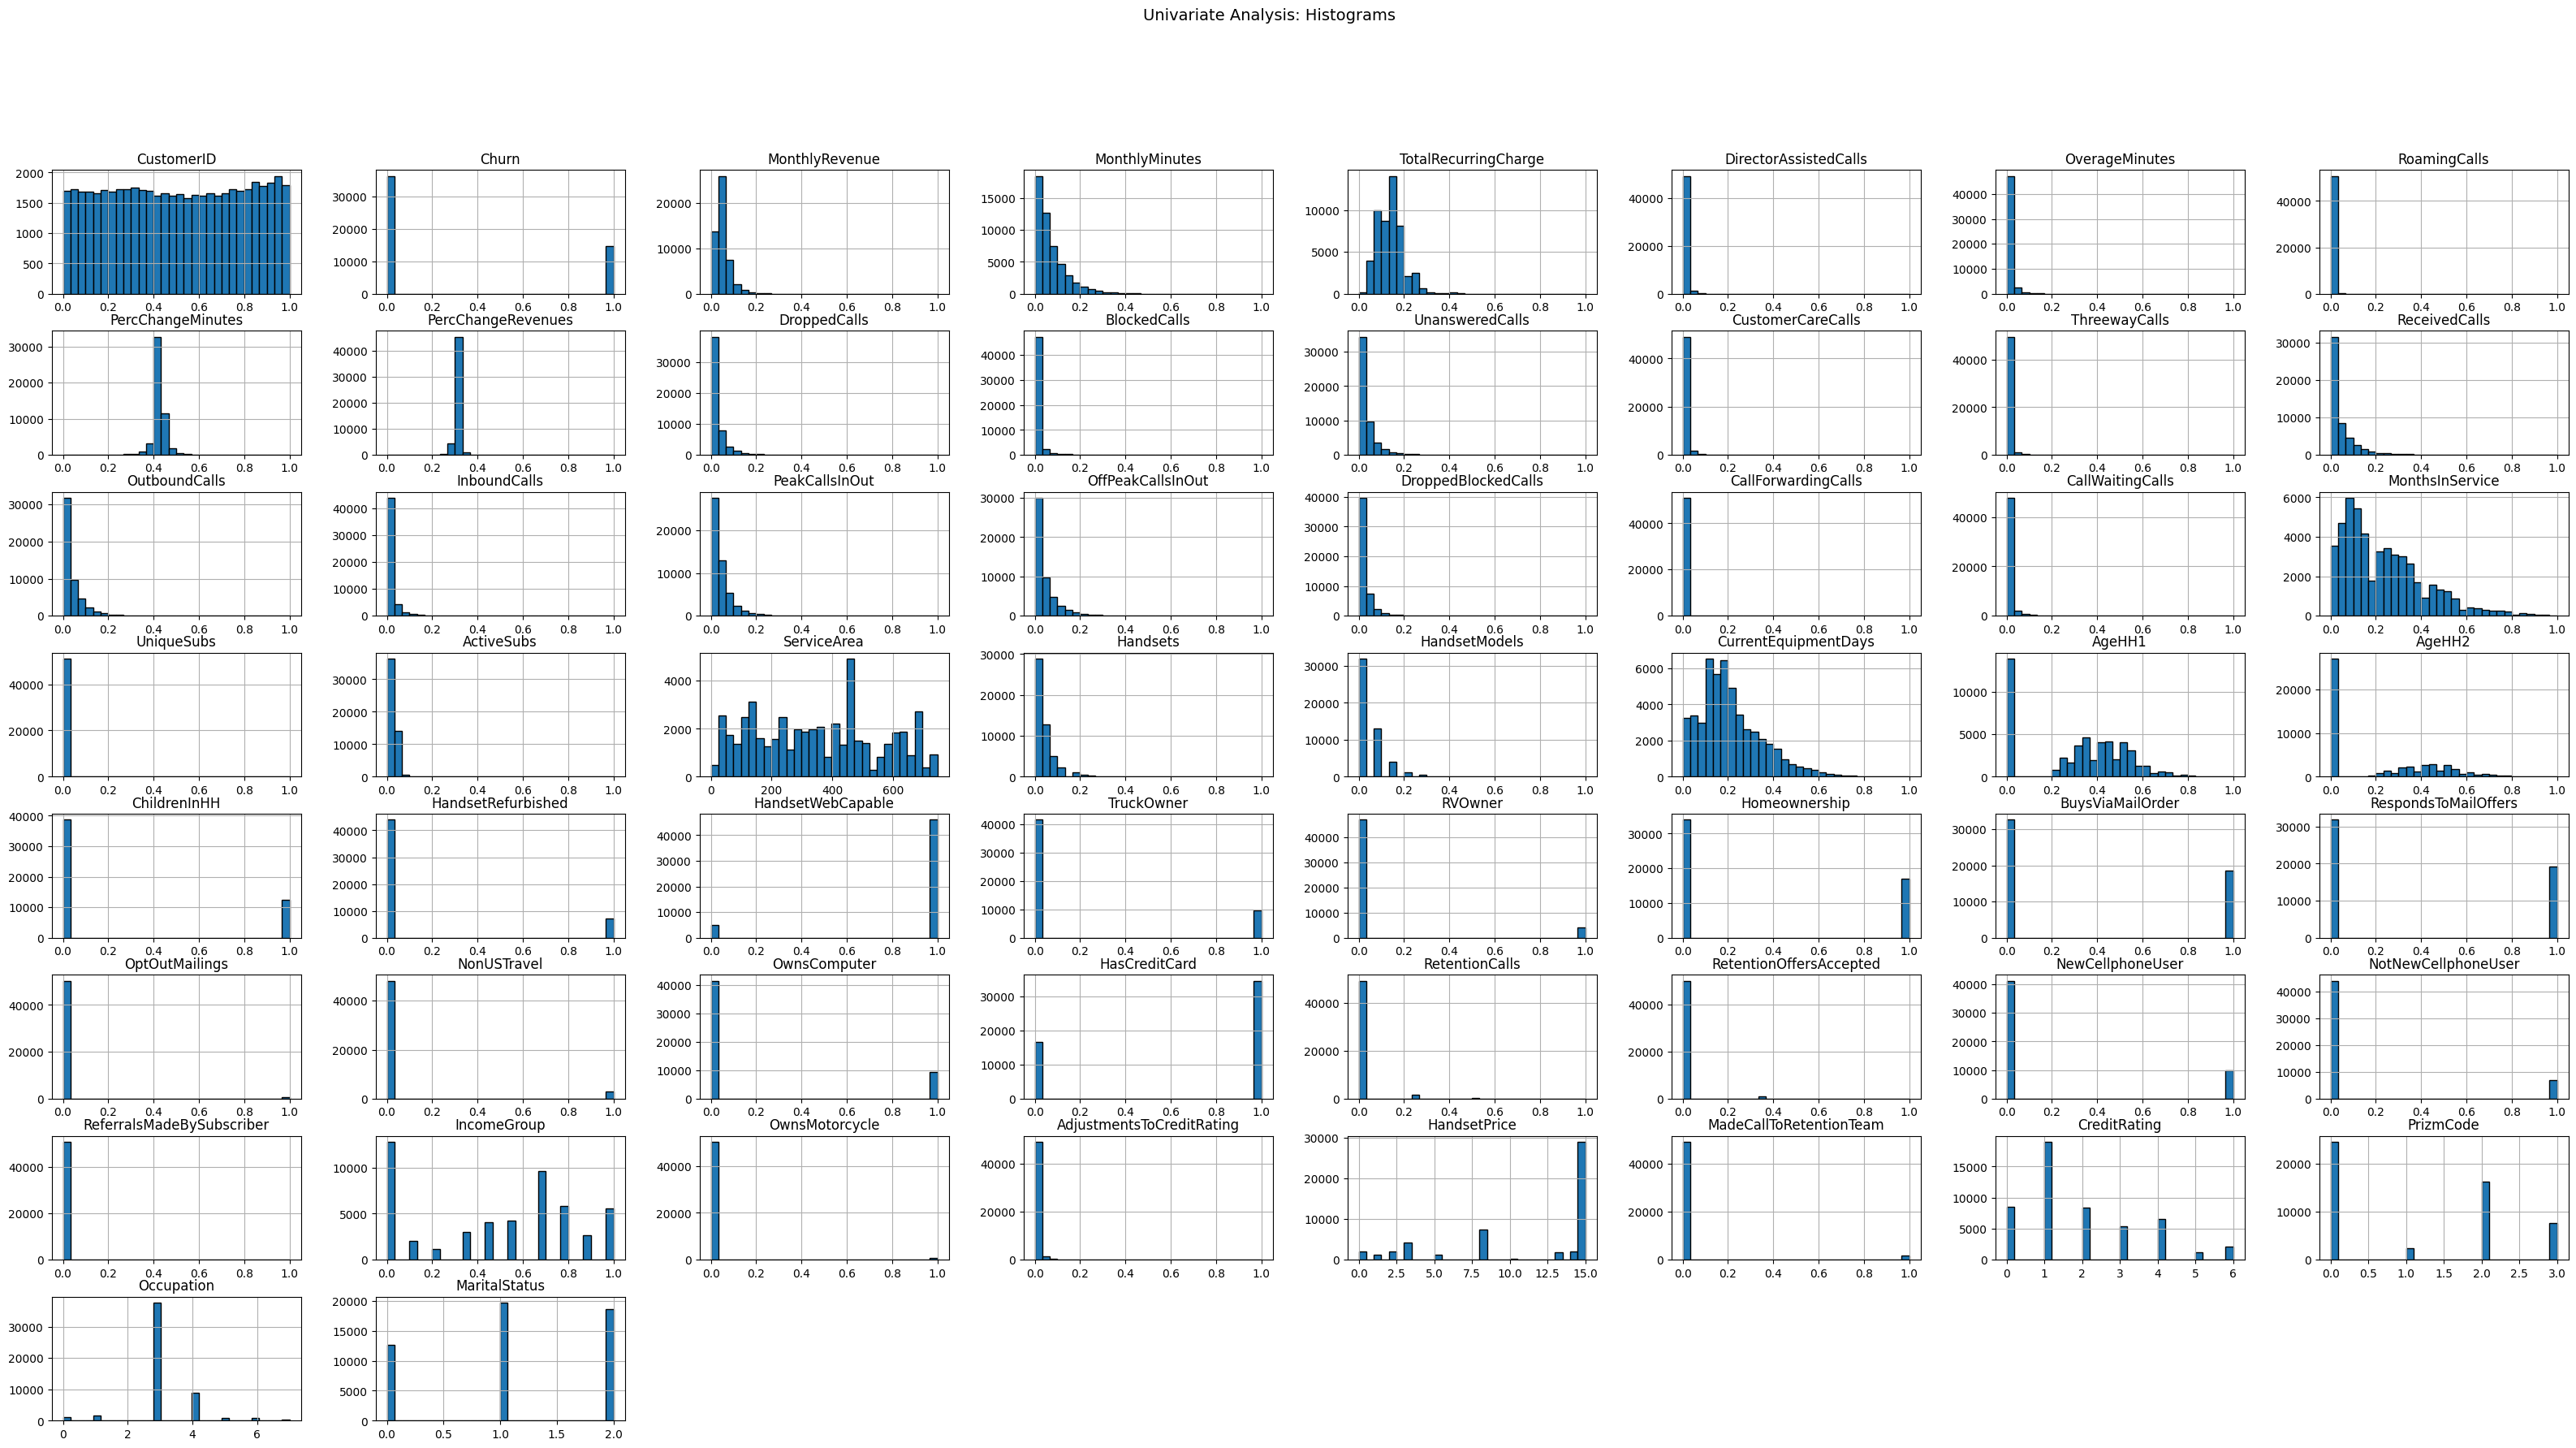

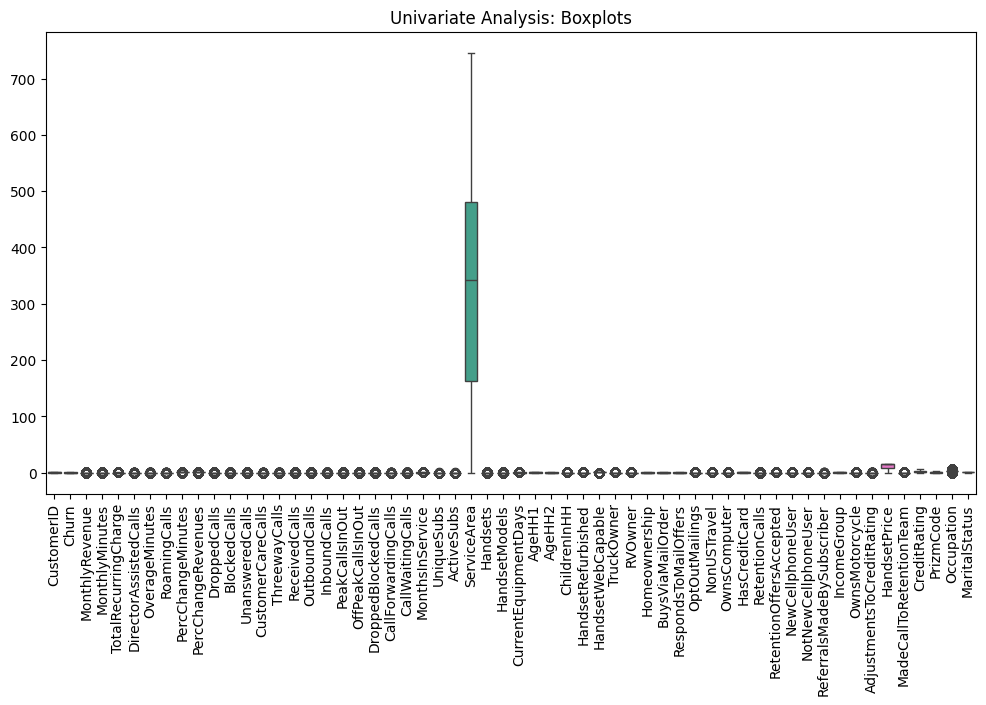


=== Bivariate Analysis ===


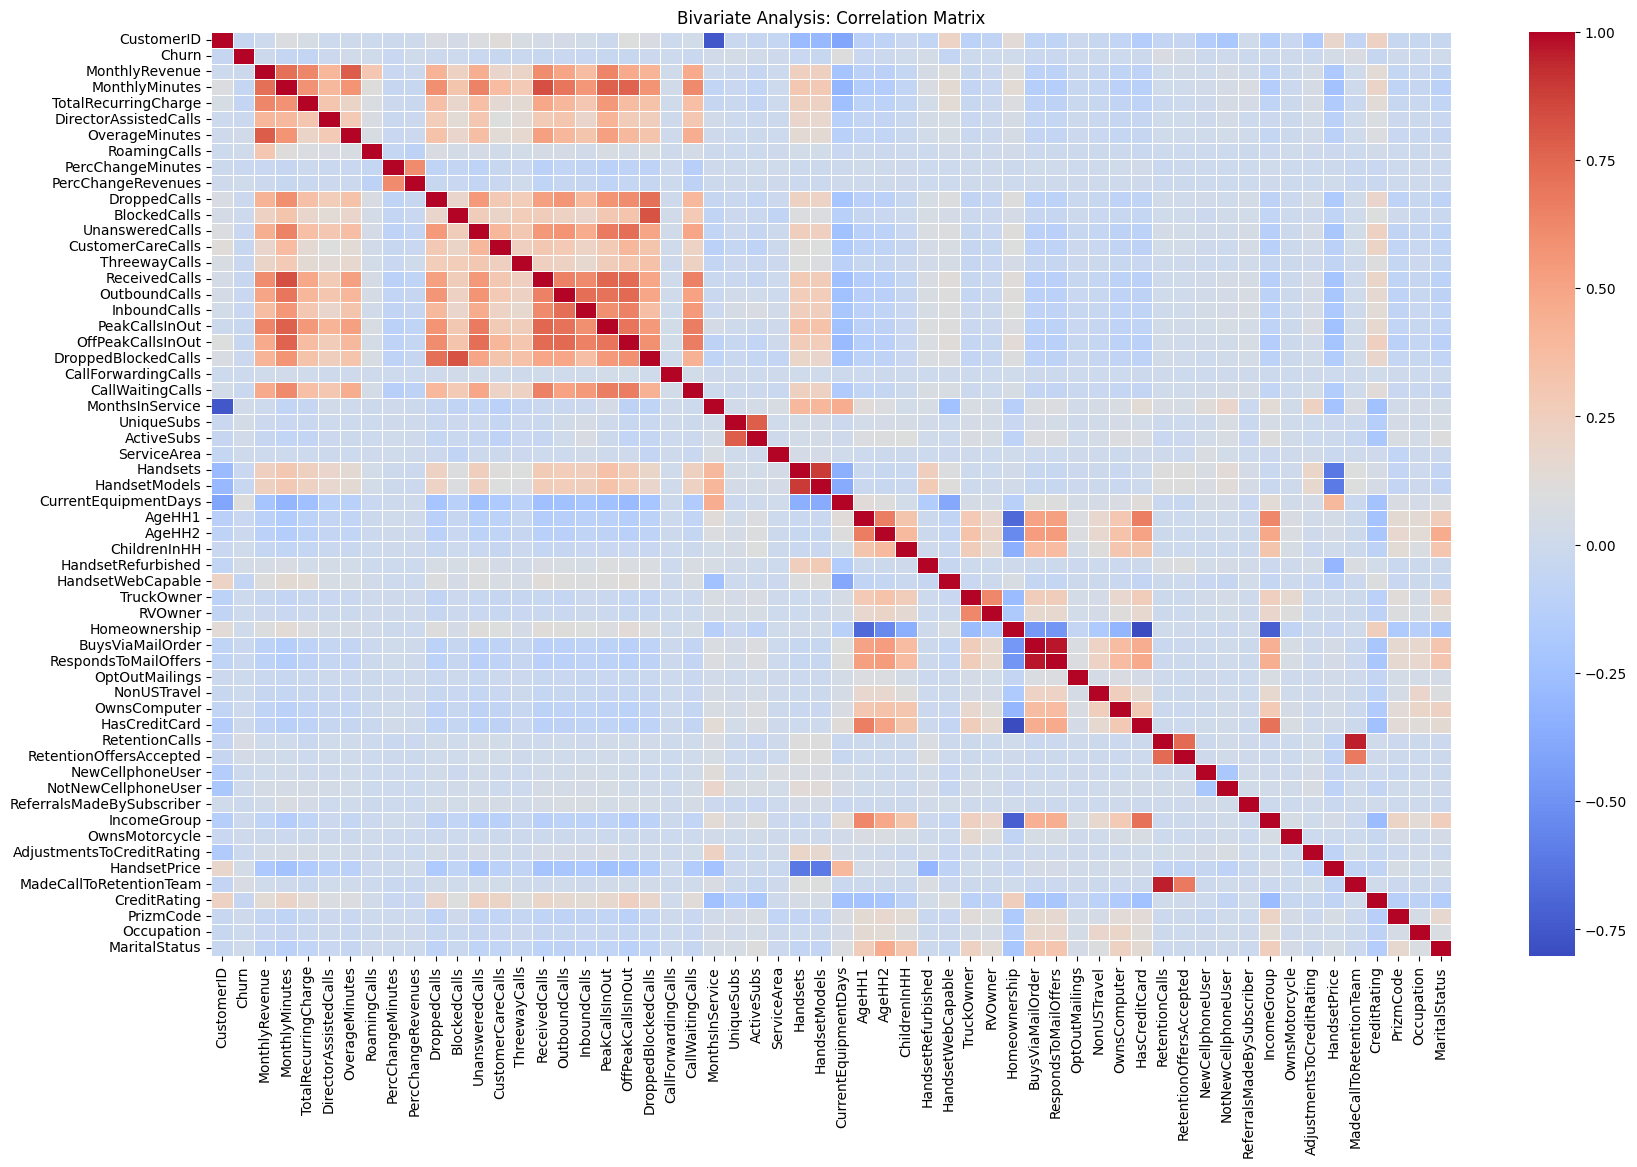

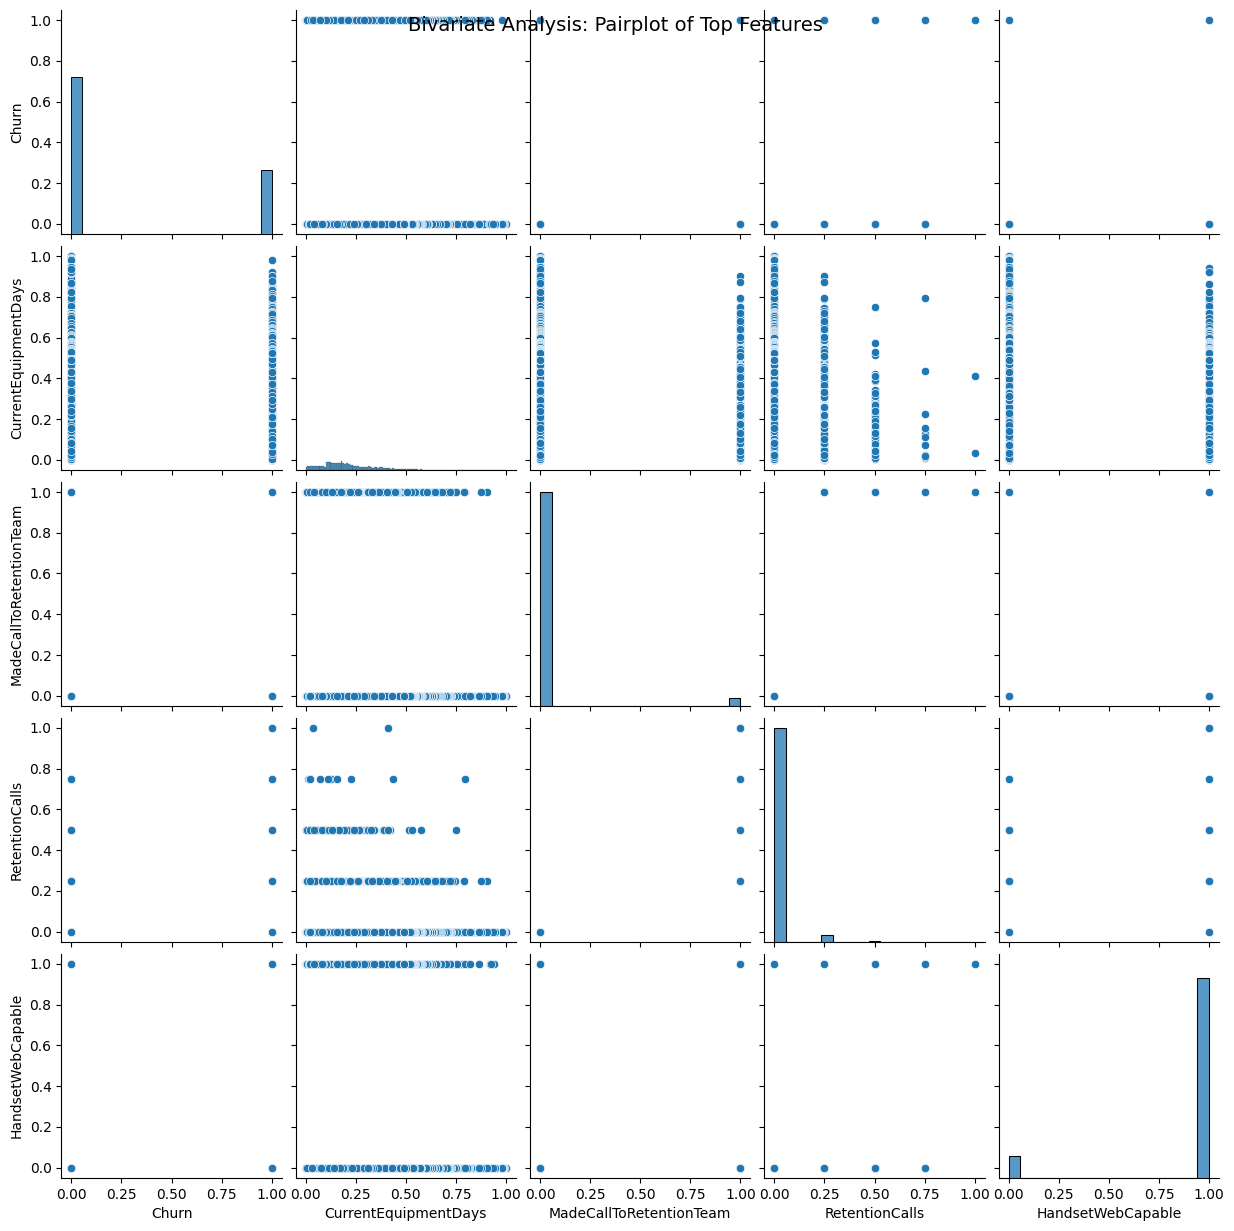

In [17]:
# Run analysis on cleaned dataset
univariate_analysis(cell2cell_df)
bivariate_analysis(cell2cell_df, target_col="Churn")

# Chi-square scores computation

In [15]:
excluded_columns = ["Churn", "CustomerID", "ServiceArea"]
X = cell2cell_df[numerical_features + categorical_features].drop(columns=excluded_columns, errors='ignore')
y = cell2cell_df['Churn']
chi2_scores, p_values = chi2(X, y)

In [20]:
chi2_results = pd.DataFrame({"Feature": X.columns, "Chi-Square Score": chi2_scores, "p-value": p_values})
chi2_results = chi2_results.sort_values(by="Chi-Square Score", ascending=False)
top_features = chi2_results["Feature"].head(20).tolist()
chi2_results['Feature'].head(20)

,Feature
50,MadeCallToRetentionTeam
51,CreditRating
49,HandsetPrice
29,RetentionCalls
26,CurrentEquipmentDays
35,HandsetRefurbished
30,RetentionOffersAccepted
36,HandsetWebCapable
41,RespondsToMailOffers
40,BuysViaMailOrder


In [ ]:
def print_metrics(model_name, accuracy, precision, recall, f1, auc):
    print(f"\n=== {model_name} Metrics ===")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1-Score: {f1:.2f}%")
    print(f"AUC: {auc:.2f}%")

# Without Smote

In [21]:
X = cell2cell_df[top_features]
y = cell2cell_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Linear Regression**

In [22]:
# lr_model = LogisticRegression(max_iter=1000)
lr_model = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')
lr_model.fit(X_train_scaled, y_train)

y_pred = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
auc_lr = roc_auc_score(y_test, y_prob_lr) * 100

print_metrics("Logistic Regression", accuracy, precision, recall, f1, auc_lr)


=== Logistic Regression Metrics ===
Accuracy: 71.34%
Precision: 41.89%
Recall: 2.14%
F1-Score: 4.07%
AUC: 59.20%


**Decision Tree**

In [23]:
dt_model = DecisionTreeClassifier(criterion='entropy', min_samples_split=50, max_depth=10, random_state=42)
dt_model.fit(X_train_scaled, y_train)

y_pred = dt_model.predict(X_test_scaled)
y_prob_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
auc_dt = roc_auc_score(y_test, y_prob_dt) * 100

print_metrics("Decision Tree", accuracy, precision, recall, f1, auc_dt)


=== Decision Tree Metrics ===
Accuracy: 71.48%
Precision: 49.09%
Recall: 9.30%
F1-Score: 15.64%
AUC: 61.59%


**Random Forest**

In [24]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
  )
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_pred_adjusted = np.where(y_prob_rf > 0.4, 1, 0)

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred_adjusted) * 100
recall = recall_score(y_test, y_pred_adjusted) * 100
f1 = f1_score(y_test, y_pred_adjusted) * 100
auc_rf = roc_auc_score(y_test, y_prob_rf) * 100

print_metrics("Random Forest", accuracy, precision, recall, f1, auc_rf)


=== Random Forest Metrics ===
Accuracy: 72.07%
Precision: 48.31%
Recall: 14.75%
F1-Score: 22.60%
AUC: 64.31%


**Naive Bayes**

In [25]:
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

y_pred = nb_model.predict(X_test_scaled)
y_prob_nb = nb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_adjusted = np.where(y_prob_nb > 0.6, 1, 0)

accuracy = accuracy_score(y_test, y_pred) * 100
precision_adj = precision_score(y_test, y_pred_adjusted) * 100
recall_adj = recall_score(y_test, y_pred_adjusted) * 100
f1_adj = f1_score(y_test, y_pred_adjusted) * 100
auc_nb = roc_auc_score(y_test, y_prob_nb) * 100

print_metrics("Naive Bayes", accuracy, precision, recall, f1, auc_nb)


=== Naive Bayes Metrics ===
Accuracy: 68.81%
Precision: 48.31%
Recall: 14.75%
F1-Score: 22.60%
AUC: 56.96%


**Adaboost**

In [26]:
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)
ada_model.fit(X_train_scaled, y_train)

y_pred = ada_model.predict(X_test_scaled)
y_prob_ada = ada_model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall = recall_score(y_test, y_pred) * 100
f1 = f1_score(y_test, y_pred) * 100
auc_ada = roc_auc_score(y_test, y_prob_ada) * 100

print_metrics("Adaboost", accuracy, precision, recall, f1, auc_ada)


=== Adaboost Metrics ===
Accuracy: 71.87%
Precision: 61.72%
Recall: 2.72%
F1-Score: 5.21%
AUC: 62.49%


**XGBoost**

In [27]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]


accuracy = accuracy_score(y_test, y_pred_xgb) * 100
precision = precision_score(y_test, y_pred_xgb) * 100
recall = recall_score(y_test, y_pred_xgb) * 100
f1 = f1_score(y_test, y_pred_xgb) * 100
auc_xgb = roc_auc_score(y_test, y_prob_xgb) * 100

print_metrics("XGBoost", accuracy, precision, recall, f1, auc_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost Metrics ===
Accuracy: 72.06%
Precision: 57.02%
Recall: 6.86%
F1-Score: 12.24%
AUC: 64.49%


**ROC Curves**

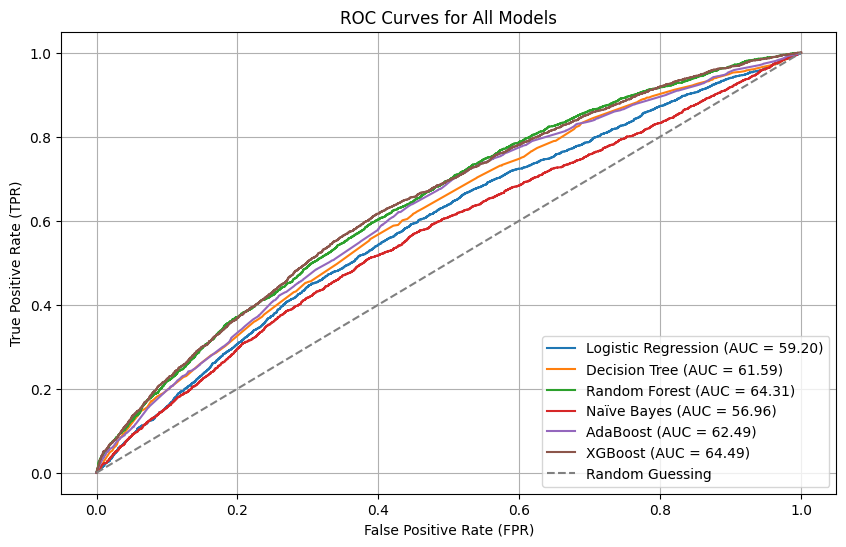

In [28]:
models = {
    "Logistic Regression": y_prob_lr,
    "Decision Tree": y_prob_dt,
    "Random Forest": y_prob_rf,
    "Naïve Bayes": y_prob_nb,
    "AdaBoost": y_prob_ada,
    "XGBoost": y_prob_xgb
}

plt.figure(figsize=(10, 6))

for model_name, y_prob in models.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc*100:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# With smote

In [29]:
print("Class distribution before SMOTE:")
print(y.value_counts())

Class distribution before SMOTE:
Churn
0    36336
1    14711
Name: count, dtype: int64


In [30]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("Class distribution after SMOTE:")
print(np.bincount(y_smote))

Class distribution after SMOTE:
[36336 36336]


In [31]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42
)

In [32]:
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_smote_scaled = scaler.transform(X_test_smote)

**Linear Regression**

In [33]:
# lr_model = LogisticRegression(max_iter=1000)
lr_model = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')
lr_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = lr_model.predict(X_test_smote_scaled)
y_prob_lr = lr_model.predict_proba(X_test_smote_scaled)[:, 1]

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision = precision_score(y_test_smote, y_pred) * 100
recall = recall_score(y_test_smote, y_pred) * 100
f1 = f1_score(y_test_smote, y_pred) * 100
auc_lr = roc_auc_score(y_test_smote, y_prob_lr) * 100

print_metrics("Logistic Regression", accuracy, precision, recall, f1, auc_lr)


=== Logistic Regression Metrics ===
Accuracy: 57.05%
Precision: 58.14%
Recall: 52.49%
F1-Score: 55.17%
AUC: 59.78%


**Decision Tree**

In [34]:
dt_model = DecisionTreeClassifier(criterion='entropy', min_samples_split=50, max_depth=10, random_state=42)
dt_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = dt_model.predict(X_test_smote_scaled)
y_prob_dt = dt_model.predict_proba(X_test_smote_scaled)[:, 1]

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision = precision_score(y_test_smote, y_pred) * 100
recall = recall_score(y_test_smote, y_pred) * 100
f1 = f1_score(y_test_smote, y_pred) * 100
auc_dt = roc_auc_score(y_test_smote, y_prob_dt) * 100

print_metrics("Decision Tree", accuracy, precision, recall, f1, auc_dt)


=== Decision Tree Metrics ===
Accuracy: 67.71%
Precision: 72.27%
Recall: 58.22%
F1-Score: 64.49%
AUC: 74.51%


**Random Forest**

In [35]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
  )
rf_model.fit(X_train_smote, y_train_smote)

y_pred = rf_model.predict(X_test_smote)
y_prob_rf = rf_model.predict_proba(X_test_smote)[:, 1]
y_pred_adjusted = np.where(y_prob_rf > 0.4, 1, 0)

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision = precision_score(y_test_smote, y_pred) * 100
recall = recall_score(y_test_smote, y_pred) * 100
f1 = f1_score(y_test_smote, y_pred) * 100
auc_rf = roc_auc_score(y_test_smote, y_prob_rf) * 100

print_metrics("Random Forest", accuracy, precision, recall, f1, auc_rf)


=== Random Forest Metrics ===
Accuracy: 68.26%
Precision: 67.47%
Recall: 71.40%
F1-Score: 69.38%
AUC: 75.65%


**Naive Bayes**

In [36]:
nb_model = GaussianNB()
nb_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = nb_model.predict(X_test_smote_scaled)
y_prob_nb = nb_model.predict_proba(X_test_smote_scaled)[:, 1]
y_pred_adjusted = np.where(y_prob_nb > 0.6, 1, 0)

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision = precision_score(y_test_smote, y_pred) * 100
recall = recall_score(y_test_smote, y_pred) * 100
f1 = f1_score(y_test_smote, y_pred) * 100
auc_nb = roc_auc_score(y_test_smote, y_prob_nb) * 100

print_metrics("Naive Bayes", accuracy, precision, recall, f1, auc_nb)


=== Naive Bayes Metrics ===
Accuracy: 56.46%
Precision: 57.85%
Recall: 49.83%
F1-Score: 53.54%
AUC: 58.47%


**Adaboost**

In [37]:
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)
ada_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = ada_model.predict(X_test_smote_scaled)
y_prob_ada = ada_model.predict_proba(X_test_smote_scaled)[:, 1]

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision = precision_score(y_test_smote, y_pred) * 100
recall = recall_score(y_test_smote, y_pred) * 100
f1 = f1_score(y_test_smote, y_pred) * 100
auc_ada = roc_auc_score(y_test_smote, y_prob_ada) * 100

print_metrics("Adaboost", accuracy, precision, recall, f1, auc_ada)


=== Adaboost Metrics ===
Accuracy: 64.00%
Precision: 63.82%
Recall: 65.80%
F1-Score: 64.80%
AUC: 69.40%


**XGBoost**

In [38]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb_model.fit(X_train_smote_scaled, y_train_smote)

y_pred = xgb_model.predict(X_test_smote_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_smote_scaled)[:, 1]

accuracy = accuracy_score(y_test_smote, y_pred) * 100
precision = precision_score(y_test_smote, y_pred) * 100
recall = recall_score(y_test_smote, y_pred) * 100
f1 = f1_score(y_test_smote, y_pred) * 100
auc_xgb = roc_auc_score(y_test_smote, y_prob_xgb) * 100

print_metrics("XGBoost", accuracy, precision, recall, f1, auc_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:27:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== XGBoost Metrics ===
Accuracy: 72.21%
Precision: 75.42%
Recall: 66.46%
F1-Score: 70.66%
AUC: 79.91%


**ROC Curves**

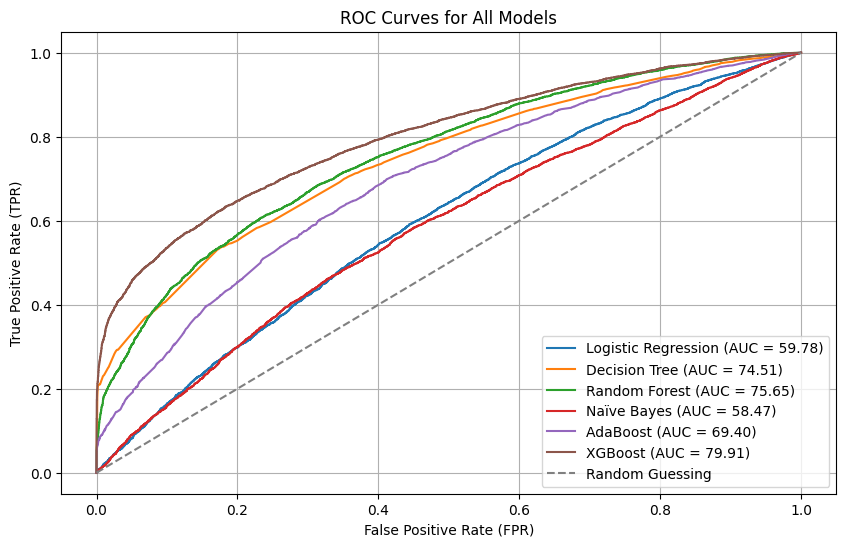

In [39]:
models = {
    "Logistic Regression": y_prob_lr,
    "Decision Tree": y_prob_dt,
    "Random Forest": y_prob_rf,
    "Naïve Bayes": y_prob_nb,
    "AdaBoost": y_prob_ada,
    "XGBoost": y_prob_xgb
}

plt.figure(figsize=(10, 6))

for model_name, y_prob in models.items():
    fpr, tpr, _ = roc_curve(y_test_smote, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc*100:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Bayesian Logistic Regression

In [40]:
X = cell2cell_df[top_features]
y = cell2cell_df['Churn']

In [41]:
with pm.Model() as bayesian_model:
    beta = pm.Normal("beta", mu=0, sigma=1, shape=len(top_features))
    intercept = pm.Normal("intercept", mu=0, sigma=1)

    logit_p = intercept + pm.math.dot(X, beta)
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=y)

    trace = pm.sample(3000, chains=2, cores=2, nuts_sampler="numpyro", return_inferencedata=True, target_accept=0.95)


/usr/local/lib/python3.11/dist-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 4000/4000 [02:05<00:00, 31.79it/s, 63 steps of size 7.91e-02. acc. prob=0.95]


In [42]:
summary = az.summary(trace, var_names=["beta"], hdi_prob=0.95)
summary["feature"] = top_features

summary = summary.sort_values("mean", ascending=False)
summary["odds_ratio"] = np.exp(summary["mean"])
summary["effect (%)"] = 100 * (summary["odds_ratio"] - 1)

summary_df = summary[['feature', 'mean', 'odds_ratio', 'effect (%)']]
summary_df

,feature,mean,odds_ratio,effect (%)
beta[4],CurrentEquipmentDays,1.366,3.919641,291.964073
beta[3],RetentionCalls,0.818,2.265963,126.596338
beta[0],MadeCallToRetentionTeam,0.640,1.896481,89.648088
beta[16],Handsets,0.587,1.798585,79.858456
beta[14],ReceivedCalls,0.420,1.521962,52.196156
beta[5],HandsetRefurbished,0.283,1.327105,32.710516
beta[17],PeakCallsInOut,0.087,1.090897,9.089668
beta[9],BuysViaMailOrder,0.040,1.040811,4.081077
beta[19],AgeHH2,0.008,1.008032,0.803209
beta[2],HandsetPrice,-0.000,1.000000,0.000000


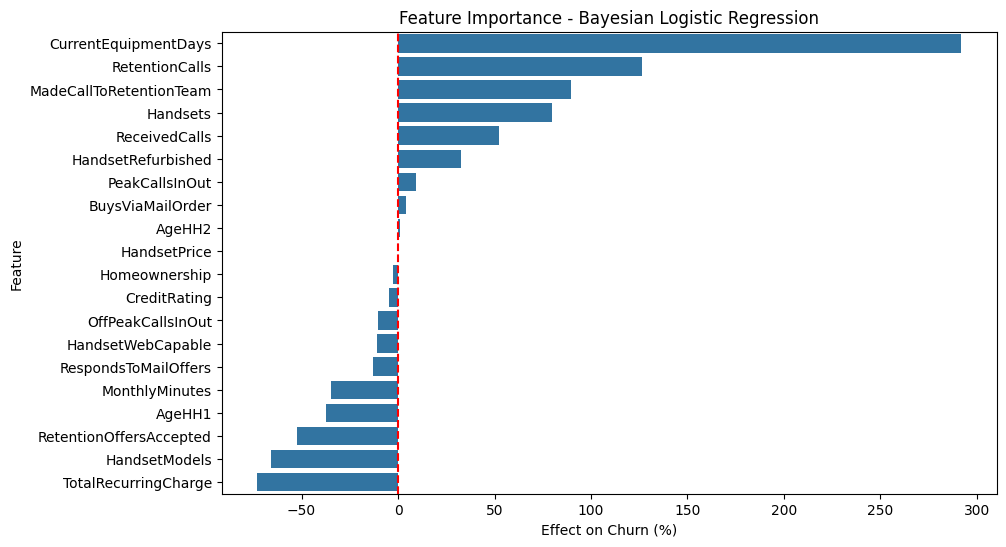

In [43]:
# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(y=summary["feature"], x=summary["effect (%)"])
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Effect on Churn (%)")
plt.ylabel("Feature")
plt.title("Feature Importance - Bayesian Logistic Regression")
plt.show()

In [44]:
def select_important_features(summary_df, num_features=16):
  sorted_features = summary_df.sort_values(by='effect (%)', key=abs, ascending=False)
  top_features = sorted_features['feature'].head(num_features).tolist()
  return top_features

important_features = select_important_features(summary_df)
important_features

['CurrentEquipmentDays',
 'RetentionCalls',
 'MadeCallToRetentionTeam',
 'Handsets',
 'TotalRecurringCharge',
 'HandsetModels',
 'RetentionOffersAccepted',
 'ReceivedCalls',
 'AgeHH1',
 'MonthlyMinutes',
 'HandsetRefurbished',
 'RespondsToMailOffers',
 'HandsetWebCapable',
 'OffPeakCallsInOut',
 'PeakCallsInOut',
 'CreditRating']

In [45]:
df_filtered = cell2cell_df[important_features + ['Churn']]
df_churned = df_filtered[df_filtered['Churn'] == 1].drop('Churn', axis=1)
df_churned

,CurrentEquipmentDays,RetentionCalls,MadeCallToRetentionTeam,Handsets,TotalRecurringCharge,HandsetModels,RetentionOffersAccepted,ReceivedCalls,AgeHH1,MonthlyMinutes,HandsetRefurbished,RespondsToMailOffers,HandsetWebCapable,OffPeakCallsInOut,PeakCallsInOut,CreditRating
0,0.201431,0.25,1,0.043478,0.080292,0.071429,0.0,0.036102,0.626263,0.029759,0,1,1,0.016274,0.027742,0
1,0.830490,0.00,0,0.043478,0.068127,0.000000,0.0,0.000000,0.404040,0.001359,0,1,0,0.000678,0.002392,3
4,0.471657,0.00,0,0.130435,0.068127,0.142857,0.0,0.000000,0.464646,0.000000,0,1,0,0.000000,0.000000,0
15,0.081453,0.25,1,0.130435,0.270073,0.142857,0.0,0.191353,0.484848,0.268787,0,1,1,0.040890,0.343426,0
18,0.429829,0.00,0,0.086957,0.068127,0.142857,0.0,0.000000,0.363636,0.005707,0,0,1,0.000475,0.001435,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51031,0.176114,0.00,0,0.043478,0.099757,0.071429,0.0,0.000000,0.000000,0.003805,0,0,1,0.000000,0.000000,3
51033,0.522840,0.00,0,0.000000,0.099757,0.000000,0.0,0.036770,0.363636,0.043484,0,1,1,0.076151,0.064906,0
51041,0.271877,0.00,0,0.043478,0.099757,0.071429,0.0,0.008060,0.222222,0.052181,0,0,1,0.036821,0.047496,4
51042,0.292240,0.00,0,0.043478,0.136253,0.071429,0.0,0.021876,0.686869,0.049735,1,1,1,0.022581,0.076673,0


**Elbow criteria and Silhouette coefficient**

In [46]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_churned)
# X_scaled = scaler.fit_transform(df_filtered)

In [47]:
# Define range of clusters to evaluate
k_values = range(2, 11)
sse_values = []
silhouette_scores = []

for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  labels = kmeans.fit_predict(X_scaled)
  sse_values.append(kmeans.inertia_)
  silhouette_scores.append(silhouette_score(X_scaled, labels))

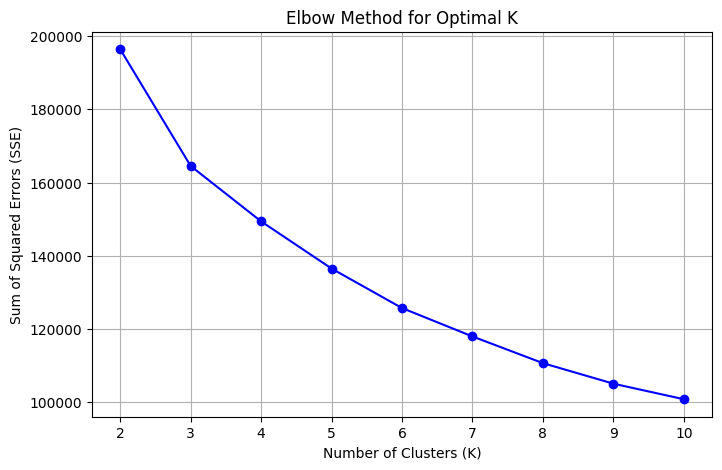

In [48]:
# Plot SSE vs. K-value
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse_values, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.title("Elbow Method for Optimal K")
plt.grid()
plt.show()

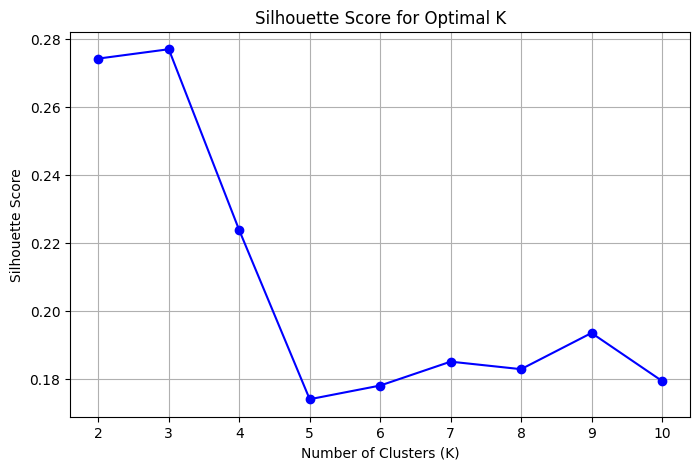

In [49]:
# Plot Silhouette Score vs. Number of Clusters
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal K")
plt.grid()
plt.show()

# K-Means Clustering

In [50]:
# Apply K-Means with the optimal number of clusters (K=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_churned['Cluster'] = kmeans.fit_predict(X_scaled)

# Count samples in each cluster
cluster_counts = df_churned['Cluster'].value_counts().sort_index()

# Display cluster sizes
for i, count in enumerate(cluster_counts):
    percentage = (count / len(df_churned)) * 100
    print(f"Cluster {i+1}: {count} samples ({percentage:.2f}%)")

Cluster 1: 10626 samples (72.23%)
Cluster 2: 780 samples (5.30%)
Cluster 3: 3305 samples (22.47%)


In [51]:
centroids = df_churned.groupby('Cluster').mean()
print('\nCluster centroids:')
print(centroids)


Cluster centroids:
         CurrentEquipmentDays  RetentionCalls  MadeCallToRetentionTeam  \
Cluster                                                                  
0                    0.266814        0.000000                 0.000000   
1                    0.210489        0.273397                 1.000000   
2                    0.138276        0.000454                 0.001815   

         Handsets  TotalRecurringCharge  HandsetModels  \
Cluster                                                  
0        0.017860              0.121417       0.019702   
1        0.055128              0.127332       0.060348   
2        0.072183              0.180992       0.081932   

         RetentionOffersAccepted  ReceivedCalls    AgeHH1  MonthlyMinutes  \
Cluster                                                                     
0                       0.000000       0.017261  0.324259        0.038892   
1                       0.163675       0.039257  0.306138        0.066005   
2         

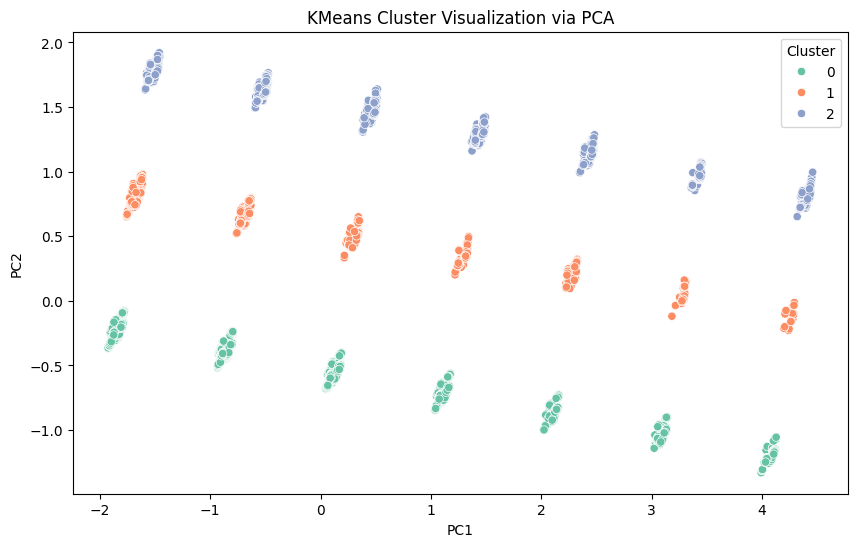

In [52]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(df_churned)

df_pca = pd.DataFrame(components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = kmeans.labels_  # add cluster labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title('KMeans Cluster Visualization via PCA')
plt.show()


In [53]:
for col in df_churned.columns:
    low, high = np.percentile(df_churned[col], [33, 67])
    print(f"{col}: Low={low}, High={high}")

CurrentEquipmentDays: Low=0.17171161254815628, High=0.2663731425426527
RetentionCalls: Low=0.0, High=0.0
MadeCallToRetentionTeam: Low=0.0, High=0.0
Handsets: Low=0.0, High=0.043478260869565216
TotalRecurringCharge: Low=0.10462287104622872, High=0.14841849148418493
HandsetModels: Low=0.0, High=0.07142857142857142
RetentionOffersAccepted: Low=0.0, High=0.0
ReceivedCalls: Low=0.005348388055266677, High=0.03713044124201458
AgeHH1: Low=0.26262626262626265, High=0.4444444444444445
MonthlyMinutes: Low=0.025954613398559586, High=0.0716129908955021
HandsetRefurbished: Low=0.0, High=0.0
RespondsToMailOffers: Low=0.0, High=1.0
HandsetWebCapable: Low=1.0, High=1.0
OffPeakCallsInOut: Low=0.00969688750254289, High=0.04000813724825388
PeakCallsInOut: Low=0.014349261013057828, High=0.043669584349739325
CreditRating: Low=1.0, High=2.0
Cluster: Low=0.0, High=0.0


In [54]:
df_churned_scaled = (df_churned - df_churned.min()) / (df_churned.max() - df_churned.min())

centroid_df = pd.DataFrame(centroids, index=["C1", "C2", "C3"])

def classify_value(val, feature_name, df_original):
    col_values = df_original[feature_name]
    low, high = np.percentile(col_values, [25, 75])

    # If all values are the same, classify based on absolute value
    if low == high:
        if val == 0:
            return "L"
        else:
            return "H"

    if val <= low:
        return "L"
    elif val >= high:
        return "H"
    else:
        return "M"

# Apply classification
classified = centroid_df.apply(lambda col: [classify_value(v, col.name, df_churned_scaled) for v in col], axis=0)

# Convert to DataFrame
classified_df = pd.DataFrame(classified, index=["C1", "C2", "C3"])

print(classified_df)

   CurrentEquipmentDays RetentionCalls MadeCallToRetentionTeam Handsets  \
C1                    M              H                       H        M   
C2                    M              H                       H        M   
C3                    M              H                       H        M   

   TotalRecurringCharge HandsetModels RetentionOffersAccepted ReceivedCalls  \
C1                    M             M                       H             M   
C2                    M             M                       H             M   
C3                    M             M                       H             M   

   AgeHH1 MonthlyMinutes HandsetRefurbished RespondsToMailOffers  \
C1      M              M                  H                    M   
C2      M              M                  H                    M   
C3      M              M                  H                    M   

   HandsetWebCapable OffPeakCallsInOut PeakCallsInOut CreditRating  
C1                 H                 M  

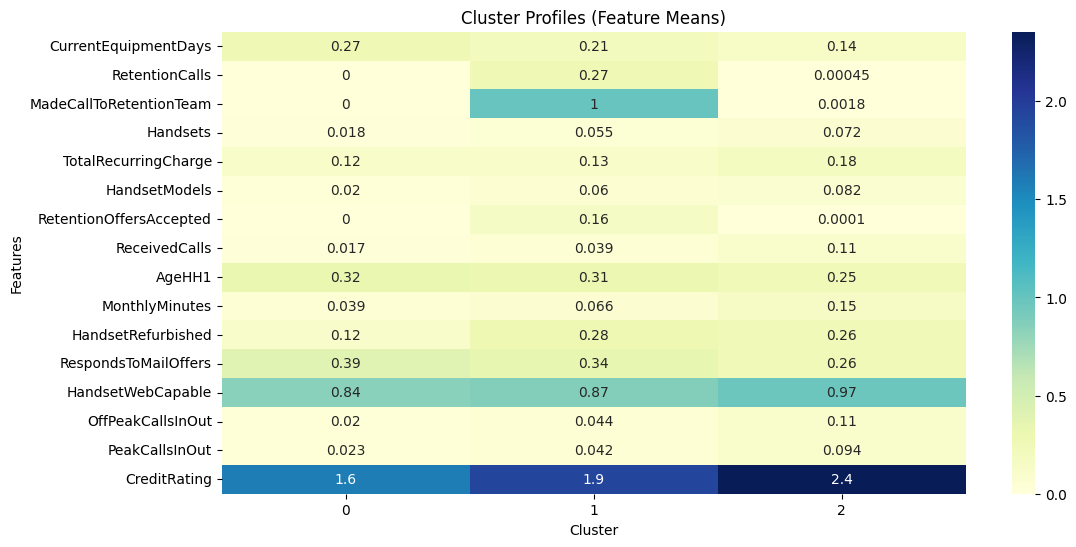

In [55]:
df_churned['Cluster'] = kmeans.labels_

# Group by cluster to get means
cluster_profiles = df_churned.groupby('Cluster').mean().T

# Optional: plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles, annot=True, cmap="YlGnBu")
plt.title("Cluster Profiles (Feature Means)")
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.show()


In [56]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Your top features
important_features = [
    'CurrentEquipmentDays', 'RetentionCalls', 'MadeCallToRetentionTeam',
    'Handsets', 'TotalRecurringCharge', 'HandsetModels', 'RetentionOffersAccepted',
    'ReceivedCalls', 'AgeHH1', 'MonthlyMinutes', 'HandsetRefurbished',
    'RespondsToMailOffers', 'HandsetWebCapable', 'OffPeakCallsInOut',
    'PeakCallsInOut', 'CreditRating'
]

# Prepare data
X = cell2cell_df[important_features]
y = cell2cell_df['Churn']

# Optional: Split if you want to evaluate it (else skip this)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Get coefficients and intercept
coefficients = lr_model.coef_[0]
intercept = lr_model.intercept_[0]

# Print them if you want to use later
print("Intercept:", intercept)
print("Coefficients:", dict(zip(important_features, coefficients)))


Intercept: -0.9204645059715046
Coefficients: {'CurrentEquipmentDays': np.float64(0.18431321099064535), 'RetentionCalls': np.float64(0.06284934081943401), 'MadeCallToRetentionTeam': np.float64(0.1018347932837012), 'Handsets': np.float64(0.020820982418111176), 'TotalRecurringCharge': np.float64(-0.0773933037937416), 'HandsetModels': np.float64(-0.05427363823723257), 'RetentionOffersAccepted': np.float64(-0.040073340652162774), 'ReceivedCalls': np.float64(0.018080420749322132), 'AgeHH1': np.float64(-0.10310821633266028), 'MonthlyMinutes': np.float64(-0.033798768246806644), 'HandsetRefurbished': np.float64(0.1058166290621577), 'RespondsToMailOffers': np.float64(-0.0535779502914707), 'HandsetWebCapable': np.float64(-0.04293931221935478), 'OffPeakCallsInOut': np.float64(-0.005491325120771196), 'PeakCallsInOut': np.float64(0.006616113724362039), 'CreditRating': np.float64(-0.07555755251442467)}


In [57]:
# Scale df_churned data using the same scaler
df_churned_scaled = scaler.transform(df_churned[important_features])

# Predict probabilities
df_churned['PredictedChurnProb'] = lr_model.predict_proba(df_churned_scaled)[:, 1]

# Assuming you already have 'Cluster' column in df_churned
churn_probs_by_cluster = df_churned.groupby('Cluster')['PredictedChurnProb'].mean()
print(churn_probs_by_cluster)


Cluster
0    0.309169
1    0.468991
2    0.254934
Name: PredictedChurnProb, dtype: float64


<ipython-input-60-241e3fb3ca45>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.96
(+292.0%)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_data.loc[feature, cluster] = f"{val:.2f}\n({effect_str})"
<ipython-input-60-241e3fb3ca45>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08
(+292.0%)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_data.loc[feature, cluster] = f"{val:.2f}\n({effect_str})"
<ipython-input-60-241e3fb3ca45>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1.04
(+292.0%)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot_data.loc[feature, cluster] = f"{val:.2f}\n({effec

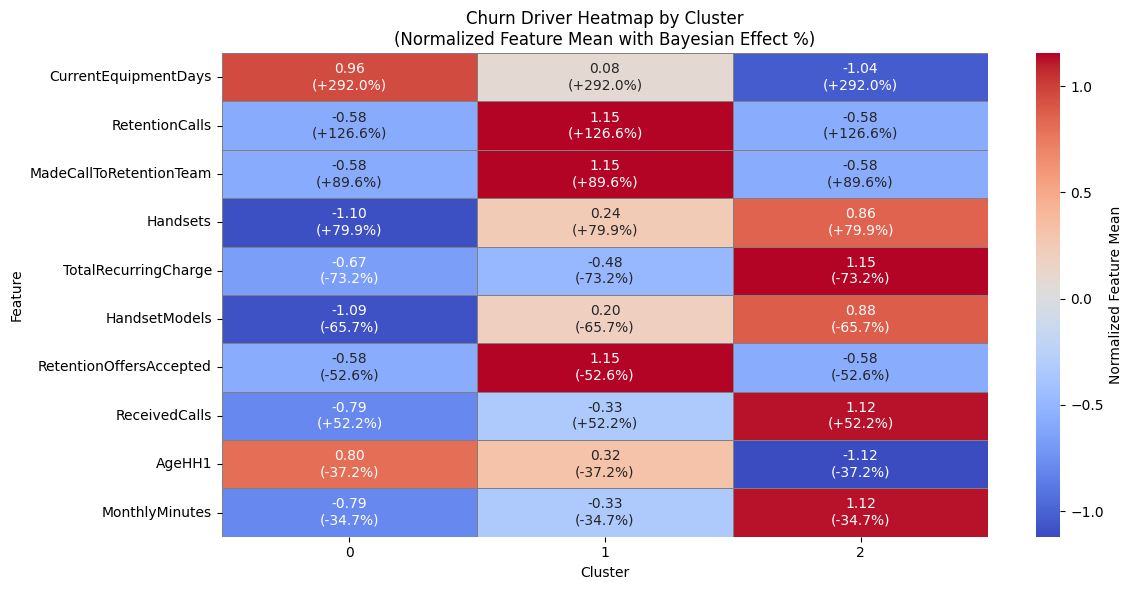

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assumes summary_df (Bayesian output) and cluster_profiles (feature means per cluster) exist

# Step 1: Get top N impactful features (by absolute effect)
top_n = 10
important_features = summary_df.sort_values("effect (%)", key=abs, ascending=False).head(top_n)
selected_features = important_features["feature"].values

# Step 2: Subset the cluster profiles
cluster_means_subset = cluster_profiles.loc[selected_features]  # shape: [features x clusters]

# Step 3: Normalize feature values for color scaling
cluster_means_norm = (cluster_means_subset - cluster_means_subset.mean(axis=1).values[:, None]) / cluster_means_subset.std(axis=1).values[:, None]

# Step 4: Annotate with effect (%) from Bayesian model
effect_mapping = dict(zip(important_features['feature'], important_features['effect (%)'].round(1)))

# Create annotation matrix: each cell shows normalized mean + effect
annot_data = cluster_means_norm.copy()
for feature in selected_features:
    effect_str = f"{effect_mapping[feature]:+}%"  # e.g., '+25%'
    for cluster in annot_data.columns:
        val = annot_data.loc[feature, cluster]
        annot_data.loc[feature, cluster] = f"{val:.2f}\n({effect_str})"

# Step 5: Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    cluster_means_norm,
    annot=annot_data,
    fmt='',
    cmap='coolwarm',
    cbar_kws={"label": "Normalized Feature Mean"},
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Churn Driver Heatmap by Cluster\n(Normalized Feature Mean with Bayesian Effect %)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
